# MATH 582 Final Project
Author: Jace Kline 2881618

In [33]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sb
from IPython.display import display

In [34]:
# load the cleaned data sets
dataloc = "./data/cleaned/"

daily = pd.read_csv(dataloc + "daily.csv")
weekly = pd.read_csv(dataloc + "weekly.csv")
monthly = pd.read_csv(dataloc + "monthly.csv")

## Correlation Analysis

Daily Correlations:


,IntensityMinutes,Steps,Stress Level,Sleep Hrs
IntensityMinutes,1.000000,-0.004817,0.230212,-0.008866
Steps,-0.004817,1.000000,0.120824,-0.032524
Stress Level,0.230212,0.120824,1.000000,-0.281616
Sleep Hrs,-0.008866,-0.032524,-0.281616,1.000000


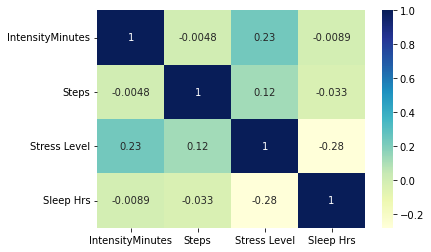

Weekly Correlations:


,IntensityMinutes,Steps,BPM,Calories,Stress Level,Sleep Hrs
IntensityMinutes,1.000000,0.414611,-0.268129,0.822681,0.049705,-0.340676
Steps,0.414611,1.000000,0.019227,0.281698,0.102626,-0.158968
BPM,-0.268129,0.019227,1.000000,-0.346548,0.692401,-0.168494
Calories,0.822681,0.281698,-0.346548,1.000000,0.025249,-0.433672
Stress Level,0.049705,0.102626,0.692401,0.025249,1.000000,-0.334273
Sleep Hrs,-0.340676,-0.158968,-0.168494,-0.433672,-0.334273,1.000000


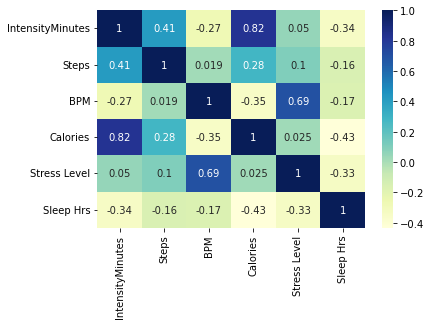

Monthly Correlations:


,BPM,Steps,Stress Level,Sleep Hrs
BPM,1.000000,-0.056197,0.698919,-0.317643
Steps,-0.056197,1.000000,0.214782,-0.791860
Stress Level,0.698919,0.214782,1.000000,-0.415714
Sleep Hrs,-0.317643,-0.791860,-0.415714,1.000000


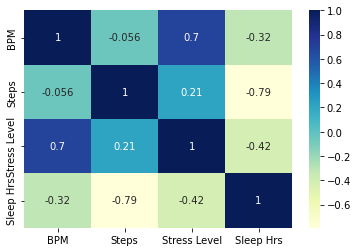

In [35]:
def show_correlations():
    dataset_labels = ["Daily", "Weekly", "Monthly"]
    datasets = [daily, weekly, monthly.drop('Month', axis=1)]

    for lbl, df in zip(dataset_labels, datasets):
        print(f"{lbl} Correlations:")
        corr = df.corr()
        display(corr)
        
        sb.heatmap(corr, cmap="YlGnBu", annot=True)
        mp.show()

show_correlations()